## <font color="darkblue"> ML models to predict Illegal fishing for groundfish by near-shore fixed gear vessels off U.S. west coast</font>

Version: 1<br>
Date: 06/21/2022

#### Objective:
The objective of this project is to identify open access fixed gear fishing vessels that may have fished in Federal waters off U.S. west coast illegally based on the type of groundfish landed. 

This notebook is in support of this manuscript: "Catch compositions support machine learning-based prediction of illegal groundfish fishing off U.S. west coast"

The notebook includes:
* Code used to train and test two classification models along with performance metrics 
* Code to import West Coast commercial landings by fixed gear vessels between 2002 and 2019. These particular landings were linked to observer data in order to create the labels (i.e., Federal waters = 1, and state waters = 0). These data (weights of five species, landing receipt totals, and distances from port to sablefish fishing grounds) were normalized and do not include identifiable elements in order to protect confidentiality. The datasets are in this repo
* Code used to tune the models' hyperparameters
* Code for plots that were used in the manuscript ("Catch compositions support machine learning-based prediction of illegal groundfish fishing off U.S. west coast"). The plots outputs are identical, but scale is different because the data provided in this repo has been normalized


In [1]:
from platform import python_version
print(python_version())

3.7.9


In [2]:
# Loading packages
# import cx_Oracle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# user = "XXXX"
# host = "XXXX"
# port = "XXXX"
# sid = "XXXX"
# pswd = "XXXX"
# dsn = cx_Oracle.makedsn (host, port, sid)

# connection  = cx_Oracle.connect (user, pswd, dsn)

#### Database connection 

This commented-out code was used to connect to the database and pull then necessary variables from the master table. The master table includes all landing receipts linked to observer data, which was used  to create the labels. 

In [4]:
# pulling in landings linked to observer trips from master table 
# sql = "SELECT keyid, INITCAP(pacfin_species_name) AS species_name, area_code, (lbs * 0.453592) AS kg, INITCAP(wcgop_waters) AS origin_catch, (total_ticket_lbs * 0.453592) AS total_receipt_kg, (total_day_lbs  * 0.453592) AS total_day_kg,  dist_202m_depth FROM enf.ole_fedwater_viol  WHERE pacfin_year > 2001 AND fishery = 'GRND' AND pacfin_group_gear_code <> 'TLS' AND wcgop_trip_id IS NOT NULL AND (lbs * 0.453592)  > 10"
# wcomp = pd.read_sql(sql, con=connection)
# pd.options.display.max_columns = None

Pivot dataframe on species and fill in zeros when the species was not present on the landing receipt. 

In [5]:
# wcomp = wcomp.rename(columns={"SPECIES_NAME": "Rowid"})
# wcomp_pivot = wcomp.pivot_table('KG', ['KEYID', 'AREA_CODE', 'DIST_202M_DEPTH', 'TOTAL_DAY_KG', 'TOTAL_RECEIPT_KG'], 'Rowid') #'TOTAL_DAY_LBS'
# wcomp_pivot = wcomp_pivot.fillna(0)
# wcomp_pivot = wcomp_pivot.reset_index()

#### Variable selection
Selected the variables for training and testing the models

In [6]:
# wcomp_pivot.rename(columns={"AREA_CODE": "Label", "DIST_202M_DEPTH": "Distance 202m Depth", "TOTAL_DAY_KG": "Total Daily Kg", "TOTAL_RECEIPT_KG": "Total Receipt Kg"}, inplace=True)

# wcomp_pivot_ml = wcomp_pivot[['Label', 'Distance 202m Depth','Total Daily Kg', 'Total Receipt Kg', 'Black Rockfish', 'Cabezon', 'Kelp Greenling', 'Sablefish', 'Shortspine Thornyhead']]

In [7]:
# X = wcomp_pivot_ml

# y = X.pop('Label')

Spliting variables into train and test datasets 

In [8]:
# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)



Applying min/max scaler to training and testing data

In [9]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# # normalizing data
# x_train.loc[:,'Distance 202m Depth':'Shortspine Thornyhead'] = scaler.fit_transform(x_train.loc[:,'Distance 202m Depth':'Shortspine Thornyhead'])


# #Same scale as the training data. 
# x_test.loc[:,'Distance 202m Depth':'Shortspine Thornyhead'] = scaler.transform(x_test.loc[:,'Distance 202m Depth':'Shortspine Thornyhead'])

#### Data Export
Exporting the datasets with the variables used to create and test the models. The datasets include normalized varibles. 

In [10]:
# x_train.to_csv("x_train_illegal_fishing_proj.csv", sep=',')
# x_test.to_csv("x_test_illegal_fishing_proj.csv", sep=',')
# y_train.to_csv("y_train_illegal_fishing_proj.csv", sep=',')
# y_test.to_csv("y_test_illegal_fishing_proj.csv", sep=',')

#### Data Import
Importing the datasets with the variables used to create and test the models. These data are available to the public and are not confidential

In [11]:
x_train = pd.read_csv('x_train_illegal_fishing_proj.csv', index_col=0)
x_test = pd.read_csv('x_test_illegal_fishing_proj.csv', index_col=0)
y_train = pd.read_csv('y_train_illegal_fishing_proj.csv', index_col=0)
y_test = pd.read_csv('y_test_illegal_fishing_proj.csv', index_col=0)

In [12]:
training_df = pd.concat([x_train, y_train], axis=1)

In [13]:
# standardized numeric values based on min/max normalization
training_df.head()

,Distance 202m Depth,Total Daily Kg,Total Receipt Kg,Black Rockfish,Cabezon,Kelp Greenling,Sablefish,Shortspine Thornyhead,Label
4607,0.149373,0.002477,0.003352,0.129883,0.000000,0.0,0.000000,0.000000,0
2013,0.142093,0.001702,0.000914,0.000000,0.072043,0.0,0.000000,0.000000,0
6965,0.000000,0.003378,0.004571,0.000000,0.000000,0.0,0.003632,0.000000,0
4934,0.003198,0.004843,0.006555,0.000000,0.000000,0.0,0.001940,0.226836,1
8520,0.003198,0.003405,0.004608,0.000000,0.000000,0.0,0.003425,0.064972,1


In [14]:
training_df = pd.concat([x_train, y_train], axis=1)

training_df_col = pd.DataFrame(training_df)
num_cols = list(training_df_col.columns)

training_df_corr = training_df.loc[:, num_cols].corr()

#### Counts of labels

In [15]:
display(y_train['Label'].value_counts())
display(y_test['Label'].value_counts())

1    4199
0    3774
Name: Label, dtype: int64

1    1457
0    1201
Name: Label, dtype: int64

#### Plots
These are the plots that are in the "Catch compositions support machine learning-based prediction of illegal groundfish fishing off U.S. west coast" manuscript. The outputs are identical, but scale is different because the data provided in the repo has been normalized

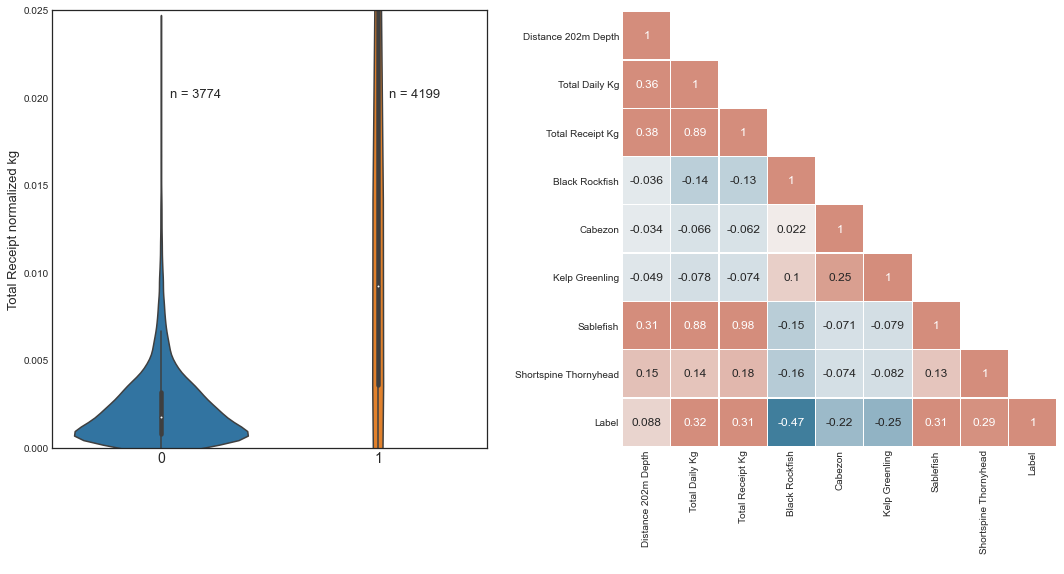

In [16]:
plt.style.use('seaborn-white') 
fig = plt.figure(figsize=(15, 8)).gca()

plt.subplot(1, 2, 1)
#plt.style.use('tableau-colorblind10') 
#fig = plt.figure(figsize=(10,7))
#ax = fig.gca()  
#sns.set_style("whitegrid")
res = sns.violinplot(x = 'Label', y = 'Total Receipt Kg', fmt='.1f', data = training_df)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)
#plt.title('Violin Plot of Total Ticket Lbs. by State and Federal Waters \n', fontsize=14)
#plt.grid()  
plt.ylim(0,0.025)
plt.text(0.04,0.02, 'n = 3774', fontsize=13)
plt.text(1.05,0.02, 'n = 4199', fontsize=13)
plt.ylabel("Total Receipt normalized kg", fontsize=13)
plt.xlabel("", fontsize=13) #Origin of Fishing
plt.tight_layout()


plt.style.use('seaborn-white') 
plt.subplot(1, 2, 2)

np.tril(np.ones(training_df_corr.shape)).astype(np.bool)[0:5,0:5]
training_corr_df = training_df_corr.where(np.tril(np.ones(training_df_corr.shape)).astype(np.bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

#sns.set(font_scale=60)
plt.style.use('fivethirtyeight')
#fig, ax = plt.subplots(figsize=(50,50))
#fig.subplots_adjust(right=0.1)
sns.heatmap(training_corr_df, vmax=.3, cmap=cmap, center=0, annot=True, annot_kws={"size": 12},
            square=True, linewidths=.25, cbar=False, cbar_kws={"shrink": 0.5})
#ax = plt.figure(figsize=(25, 10)).gca()
#plt.title('Correlation Matrix of Features and Target Variable \n', fontsize=14)
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.ylabel(" ")
plt.xlabel(" ")
plt.tight_layout()

### Random Forest Classification Model: Hyperparameter tuning

In [17]:
# randomized search

# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = list(range(63, 1000, 20)) #[int(x) for x in np.linspace(start = 100, stop = 1500, num = 35)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# criterion = ['gini', 'entropy']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 150, num = 15)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10, 15]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4, 6 ,8]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'criterion': criterion,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [18]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier() #RandomForestRegressor()
# # Random search of parameters, using 5 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')
# # Fit the random search model
# rf_random.fit(x_train, y_train)

In [19]:
# print("\n The best estimator across ALL searched params:\n", rf_random.best_estimator_)
# print("\n The best score across ALL searched params:\n", rf_random.best_score_)
# print("\n The best parameters across ALL searched params:\n", rf_random.best_params_)

### Random Forest Classification Model: Best Hyperparameters

In [20]:
# The random forest classifier - Best hyperparameters from the random grid search
from sklearn.ensemble import RandomForestClassifier 

clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=25, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=443, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from 

In [21]:
#fit model to training data
clf.fit(x_train, y_train)

# model prediction on test data
y_pred = clf.predict(x_test)

probas = clf.predict_proba(x_test)

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precis

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [22]:
# creating a confusion matrix on how well model performed on test data after training
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix

### Confusion  Metrics for Random Forest Model

In [23]:
print('Confusion Matrix for Random Forest Model')

AR = accuracy_score(y_test, y_pred)
print ("\nRandom Forest Classifier Accuracy rate:", np.round(AR, 2))
ER = 1.0 - AR
print ("\nRandom Forest Classifier Error rate:", np.round(ER, 2))
P = precision_score(y_test, y_pred)
print ("\nRandom Forest Classifier Precision:", np.round(P, 2))
R = recall_score(y_test, y_pred)
print ("\nRandom Forest Classifier Recall:", np.round(R, 2))
F1 = f1_score(y_test, y_pred)
print ("\nRandom Forest Classifier F1 score:", np.round(F1, 2))

Confusion Matrix for Random Forest Model

Random Forest Classifier Accuracy rate: 0.97

Random Forest Classifier Error rate: 0.03

Random Forest Classifier Precision: 0.97

Random Forest Classifier Recall: 0.98

Random Forest Classifier F1 score: 0.97


### Gradient Boosting Classification Model: Hyperparameter tuning

In [24]:
# The best gradient boosting classifier hyperparameters from the gridsearch with cross-fold validation.
# from sklearn.ensemble import GradientBoostingClassifier
# from scipy.stats import uniform as sp_randFloat
# from scipy.stats import randint as sp_randInt 

# gbm_clf = GradientBoostingClassifier()

In [25]:
# from sklearn.model_selection import RandomizedSearchCV

# parameters = {'learning_rate': sp_randFloat(),
#               'subsample'    : sp_randFloat(),
#               'n_estimators' : sp_randInt(100, 1000),
#               'max_depth'    : sp_randInt(2, 10),
#               'min_samples_split' : sp_randInt(2, 100),
#               'min_samples_leaf'  : sp_randInt(1, 10),
#              }

# gbc_random = RandomizedSearchCV(estimator=gbm_clf, param_distributions = parameters, 
#                            cv = 5, n_iter = 100, n_jobs=-1)
# gbc_random.fit(x_train, y_train)

In [26]:
# print (gbc_random.best_score_)
# print (gbc_random.best_params_)
# print (gbc_random.best_estimator_)

### Gradient Boosting Classification Model: Best Hyperparameters

In [27]:
# The best gradient boosting classifier.
from sklearn.ensemble import GradientBoostingClassifier

gbc_clf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.21132388285654147, loss='deviance',
               max_depth=2, max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=8, min_samples_split=79,
               min_weight_fraction_leaf=0.0, n_estimators=678,
               n_iter_no_change=None, presort='auto', random_state=None,
               subsample=0.8428730385012775, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
#fit model to training data
gbc_clf.fit(x_train, y_train)

# model prediction on test data
y_pred_gbc = gbc_clf.predict(x_test)

probas_gbc = gbc_clf.predict_proba(x_test)

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1302: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.object)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1489: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_mask = np.ones((n_samples, ), dtype=np.bool)
C:\Users\rames\AppData\Roaming\Python\Pytho

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

### Confusion Matrix for Gradient Boosting Model

In [29]:
print('Confusion Matrix for Gradient Boosting Model')

AR = accuracy_score(y_test, y_pred_gbc)
print ("\nGradient Boosting Classifier Accuracy rate:", np.round(AR, 2))
ER = 1.0 - AR
print ("\nGradient Boosting Classifier Error rate:", np.round(ER, 2))
P = precision_score(y_test, y_pred_gbc)
print ("\nGradient Boosting Classifier Precision:", np.round(P, 2))
R = recall_score(y_test, y_pred_gbc)
print ("\nGradient Boosting Classifier Recall:", np.round(R, 2))
F1 = f1_score(y_test, y_pred_gbc)
print ("\nGradient Boosting Classifier F1 score:", np.round(F1, 2))

Confusion Matrix for Gradient Boosting Model

Gradient Boosting Classifier Accuracy rate: 0.97

Gradient Boosting Classifier Error rate: 0.03

Gradient Boosting Classifier Precision: 0.97

Gradient Boosting Classifier Recall: 0.97

Gradient Boosting Classifier F1 score: 0.97


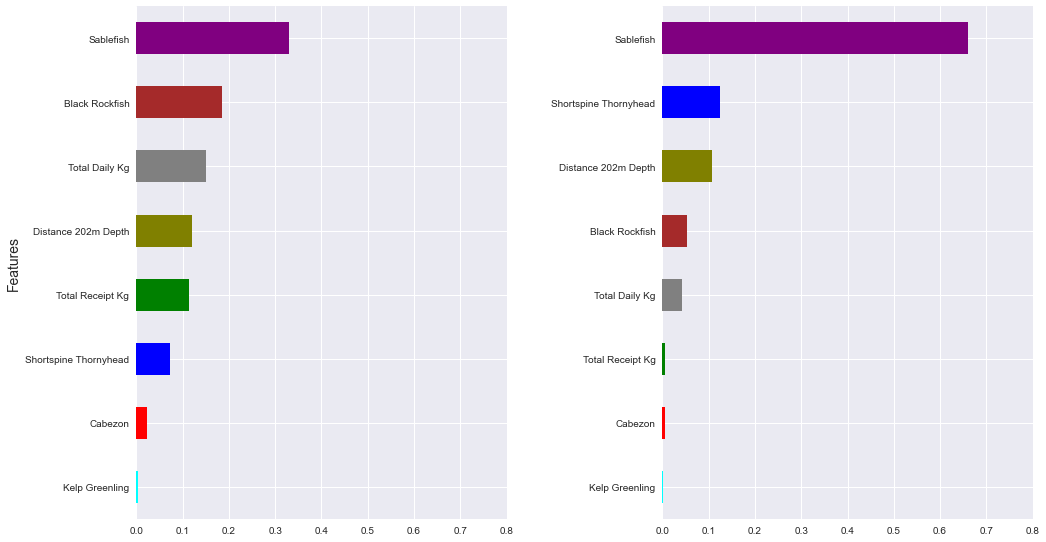

In [30]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 8)).gca()
plt.rcParams['font.size'] = '22'

plt.subplot(1, 2, 1)
#ax.xaxis.set_visible(False)

#plt.rcParams.update({'font.size': 52})

#plt.title('Features of Importances: Random Forest Model\n', fontsize=14)
feature_importances = pd.Series(clf.feature_importances_, index=x_test.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", color=['cyan', 'red', 'blue', 'green', 'olive', 'grey', 'brown', 'purple']) #, figsize=(11,7))
plt.xlim([0,0.8])
plt.ylabel("Features")
plt.ylabel("Features", fontsize=14)
plt.tight_layout()


plt.style.use('seaborn')
plt.subplot(1, 2, 2)
#plt.title('Features of Importances: Gradient Boosting Model\n', fontsize=14)
feature_importances = pd.Series(gbc_clf.feature_importances_, index=x_test.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", color=['cyan','red', 'green', 'grey', 'brown', 'olive', 'blue', 'purple']) #, figsize=(12,12))
plt.xlim([0,0.8])
plt.ylabel(" ")
plt.tight_layout()

In [31]:
LW_r = 1.5 # line width for plots
LL_r = "lower right" # legend location
LC_r = 'brown' # Line Color

fpr_r, tpr_r, th_r = roc_curve(y_test, probas[:,1]) # False Positive Rate, True Posisive Rate, probability thresholds
AUC = auc(fpr_r, tpr_r)


LW_g = 1.5 # line width for plots
LL_g = "lower right" # legend location
LC_g = 'darkblue' # Line Color

fpr_g, tpr_g, th_g = roc_curve(y_test, probas_gbc[:,1]) # False Positive Rate, True Posisive Rate, probability thresholds
AUC = auc(fpr_g, tpr_g)

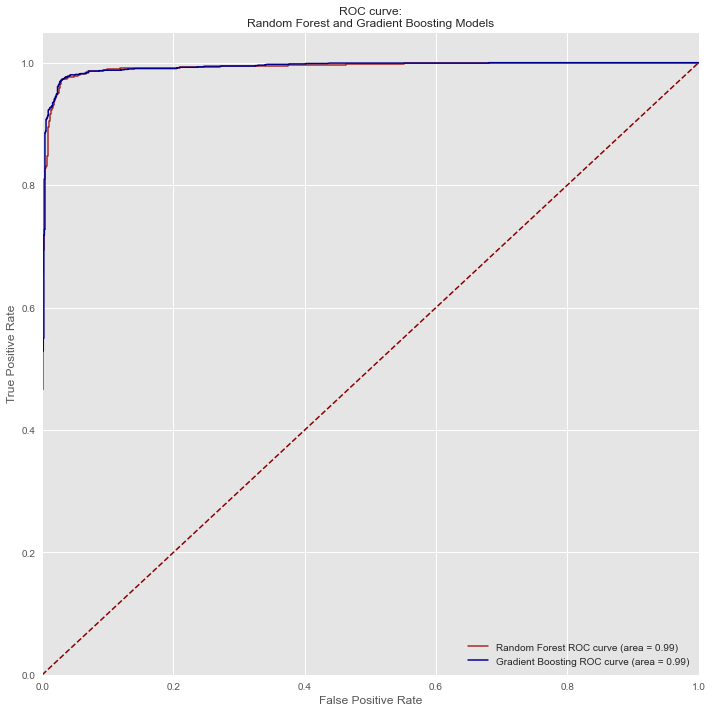

In [32]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 10)).gca()
plt.title('ROC curve:\nRandom Forest and Gradient Boosting Models', fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_r, tpr_r, color=LC_r,lw=LW_r, label='Random Forest ROC curve (area = %0.2f)' % AUC)
plt.plot(fpr_g, tpr_g, color=LC_g,lw=LW_g, label='Gradient Boosting ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='darkred', lw=LW_r, linestyle='--') # reference line for random classifier
plt.legend(loc=LL_r) 
plt.tight_layout()